In [1]:
# Import feature maps
import sys
import os
from feature_maps import IdentityLayer, RecenteringLayer, GramMatrixLayer, \
                        RecenterBondLayer, OrthogonalChangeOfBasisBatched
import torch
import diffusion_map as diffusion_map
from tqdm import tqdm

In [2]:
# get data
import numpy as np
data_dir = np.load("butane_data.npz")
data = data_dir['data_all_atom'][::10]
dihderals = data_dir['dihedrals'][::10]

# Visualize data using nglview

In [3]:
# use nglview
import nglview as nv
import mdtraj as md

In [5]:
import os 
os.getcwd()

'/Users/shashanksule/Documents/exploring_butane/additional_figs/embeddings'

In [6]:

# Load the PDB file
pdb_file = "../../simulate/data/butane.pdb"

# Load the PDB topology using mdtraj
topology = md.load_pdb(pdb_file).topology

# Create mdtraj trajectory from dataMetaD
# dataMetaD has shape (200000, 42) = (n_frames, n_atoms * 3)
# We need to reshape it to (n_frames, n_atoms, 3) for mdtraj
n_frames, n_coords = data.shape
n_atoms = n_coords // 3

# Reshape the coordinates: (n_frames, n_atoms, 3)
coordinates = data.reshape(n_frames, n_atoms, 3)

# Create the mdtraj trajectory
# Note: coordinates should be in nanometers for mdtraj
# If your data is in angstroms, divide by 10
trajectory = md.Trajectory(coordinates / 10.0, topology)  # Convert Å to nm

print(f"Created trajectory with {trajectory.n_frames} frames and {trajectory.n_atoms} atoms")
print(f"Trajectory topology: {trajectory.topology}")

Created trajectory with 10000 frames and 14 atoms
Trajectory topology: <mdtraj.Topology with 1 chains, 1 residues, 14 atoms, 0 bonds>


In [9]:
# align the trajectory 
aligned_traj = trajectory.superpose(reference=trajectory, frame=0)

mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300
mdtraj/rmsd/src/theobald_rmsd.cpp UNCONVERGED ROTATION MATRIX. RETURNING IDENTITY=300


In [7]:
# Check what atoms we have in the topology
print("Atoms in topology:")
for i, atom in enumerate(topology.atoms):
    print(f"Index {i}: {atom.name} - Element: {atom.element}")
    
print(f"\nTotal atoms: {topology.n_atoms}")

Atoms in topology:
Index 0: H11 - Element: hydrogen
Index 1: H12 - Element: hydrogen
Index 2: H13 - Element: hydrogen
Index 3: C1 - Element: carbon
Index 4: H21 - Element: hydrogen
Index 5: H22 - Element: hydrogen
Index 6: C2 - Element: carbon
Index 7: H31 - Element: hydrogen
Index 8: H32 - Element: hydrogen
Index 9: C3 - Element: carbon
Index 10: H41 - Element: hydrogen
Index 11: H42 - Element: hydrogen
Index 12: H43 - Element: hydrogen
Index 13: C4 - Element: carbon

Total atoms: 14


In [10]:
import nglview as nv

# Create a view of the trajectory
view = nv.show_mdtraj(aligned_traj)

# Clear default representations
view.clear_representations()

# Remove ball_and_stick to avoid color conflicts

# Add separate representations using atom indices instead of element names
# For butane, typically first 4 atoms are carbons, rest are hydrogens
view.add_spacefill(
    selection='@3,6,9,13',  # Carbon atoms by index
    color='red',
    radius=0.5
)

view.add_spacefill(
    selection='@0,1,2,4,5,7,8,10,11,12',  # Hydrogen atoms by index
    color='blue',
    radius=0.4  # Smaller than carbons
)

# Add licorice for bonds with custom color
view.add_licorice(
    selection='all',
    color='grey',
    radius=0.15
)

# Set styling
view.camera = 'perspective'
view.background = 'white'

# Display the view
view

NGLWidget(max_frame=9999)

# Load up feature maps

In [5]:
# Example input tensor of shape [batch_size, 3N]
batch_size = data.shape[0]
N = data.shape[1] // 3 # Number of atoms

# Test GramMatrixLayer
selected_rows = [i for i in range(N)]  # Example: select the 1st and 3rd rows
all_atoms = torch.zeros(len(selected_rows), N)
for i, row in enumerate(selected_rows):
    all_atoms[i, row] = 1

selected_atoms = [3, 6, 9, 13]  # Example: select the first 4 atoms
carbons_matrix = torch.zeros(len(selected_atoms), N)
for i, atom in enumerate(selected_atoms):
    carbons_matrix[i, atom] = 1

feature_maps = {
    'NoFeaturzation': IdentityLayer(),
    'Recentering': RecenteringLayer(all_atoms),
    'GramMatrix': GramMatrixLayer(all_atoms),
    'GramMatrixCarbon': GramMatrixLayer(carbons_matrix),
    'BondAlign(1,2)': RecenterBondLayer([3, 6], batch_mode=True),
    'BondAlign(2,3)': RecenterBondLayer([6, 9], batch_mode=True),
    'OrthogonalChangeOfBasisBatched': OrthogonalChangeOfBasisBatched()
}

# Compute embedding

We first pass the data through the feature map and compute the diffusion embedding. Change the cell below to switch between different feature maps. Note also that PlaneAlign is the feature map `OrthogonalChangeOfBasisUnbatched`. 

In [10]:
feat_map_name = 'BondAlign(1,2)'  # Example feature map name
feature_map = feature_maps[feat_map_name]

In [11]:
feature_data = feature_map(torch.tensor(data.reshape(batch_size, 3 * N), dtype=torch.float32)).detach().numpy()
# compute eigenvalues and eigenvectors
eps = 50.0
dmap = diffusion_map.DiffusionMap(alpha=1.0, epsilon=eps, num_evecs=25)
dmap._compute_knn_sq_dists(feature_data.T)
dmap.construct_generator(feature_data.T)
lap = dmap.L
phi, _, Sigma = dmap._construct_diffusion_coords(lap)

done with kernel!
computing eigvec matrix


# Plot embedding

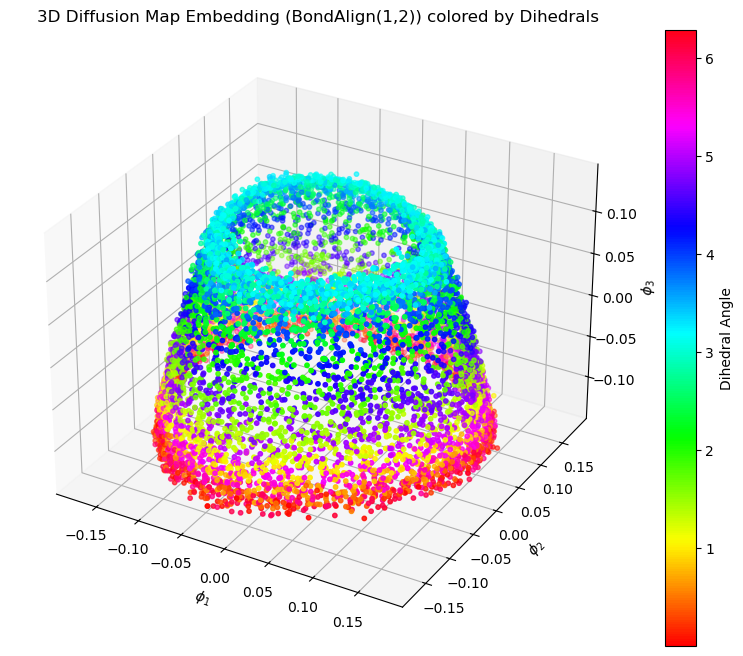

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Required for 3D plotting

# Ensure phi has at least 3 columns
if phi.shape[1] < 3:
    raise ValueError("phi must have at least 3 columns for a 3D scatter plot.")

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the 3D scatter plot
# Using the first three columns of phi for x, y, z coordinates
scatter = ax.scatter(phi[:, 0], phi[:, 1], phi[:, 2], c=dihderals, cmap='hsv', s=10)

# Add labels and title
ax.set_xlabel('$\psi_1$')
ax.set_ylabel('$\psi_2$')
ax.set_zlabel('$\psi_3$')
ax.set_title(f'3D Diffusion Map Embedding ({feat_map_name}) colored by Dihedrals')

# Add a color bar
cbar = fig.colorbar(scatter, ax=ax, label='Dihedral Angle')

plt.show()